<a href="https://colab.research.google.com/github/carson-edmonds/AAI-590_Group-3_Capstone/blob/jeremy_dev/ViT_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="text-align:center">Airborne Object Tracking - Vision Transformer (ViT) Model
</h1>

####Accessing the dataset involved the following code that was referenced in the AOT challenge website: https://www.aicrowd.com/challenges/airborne-object-tracking-challenge and with the tutorial code created by Vuong Tuan Khanh at: https://github.com/VuongTuanKhanh/Airborne-Object-Detection-and-Tracking
Helper script for easy access the dataset: https://gitlab.aicrowd.com/amazon-prime-air/airborne-detection-starter-kit/-/blob/master/docs/DATASET.md  
Model setup: https://www.aicrowd.com/showcase/sample-interface-for-training-with-darknet-yolo  
Dataset is hosted on a public AWS S3: s3://airborne-obj-detection-challenge-training/

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Funix-Capstone-Project/data

Mounted at /content/drive
/content/drive/MyDrive/Funix-Capstone-Project/data


# Imports

In [3]:
import json
import random
import os, sys, glob
from IPython.display import display, clear_output, HTML
from random import randrange, choice
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=25,25
import numpy as np
import seaborn as sns
import pandas as pd
import random

random.seed(42)

# clone repo and make directory just one time.
#!git clone https://github.com/VuongTuanKhanh/Funix-Capstone-Project.git
#os.mkdir("Funix-Capstone-Project/data")
#os.chdir("Funix-Capstone-Project/data")


## Loading Dataset (Part 1 only)

**NOTE**: You don't need to have `groundtruth.json` pre-downloaded, it will automatically download, save and load them for you.

In [4]:
# Dataset for Airborne Object Tracking Dataset
sys.path.append(os.path.dirname(os.path.realpath(os.getcwd())))
sys.path.append(os.path.dirname(os.path.realpath(os.getcwd())) + "/core")

!pip install -r ../requirements.txt > /dev/null

from core.dataset import Dataset
notebook_path = os.path.dirname(os.path.realpath("__file__"))

local_path = notebook_path + '/part1'
s3_path = 's3://airborne-obj-detection-challenge-training/part1/'
dataset = Dataset(local_path, s3_path, partial=True, prefix='part1')
dataset.add(local_path, s3_path)

2024-08-11 00:45:03.688 | INFO     | core.dataset:load_ve:57 - Loading valid encounters...
2024-08-11 00:45:04.979 | INFO     | core.dataset:load_gt:28 - Loading ground truth...
2024-08-11 00:45:20.487 | INFO     | core.dataset:load_gt:46 - Skipping flight, not present in valid encounters: 673f29c3e4b4428fa26bc55d812d45d9
2024-08-11 00:45:20.519 | INFO     | core.dataset:load_gt:46 - Skipping flight, not present in valid encounters: 63c5597a57b04b448723f1f1844a2b78
2024-08-11 00:45:20.524 | INFO     | core.dataset:load_gt:46 - Skipping flight, not present in valid encounters: 4458bb328345402c8f363b7480060393
2024-08-11 00:45:20.532 | INFO     | core.dataset:load_gt:46 - Skipping flight, not present in valid encounters: 7f5dd587c1b046efbf9e3221fe633e4e
2024-08-11 00:45:20.535 | INFO     | core.dataset:load_gt:46 - Skipping flight, not present in valid encounters: 3c349bdf14c1464bb2b30094e7297d84
2024-08-11 00:45:20.536 | INFO     | core.dataset:load_gt:46 - Skipping flight, not present 

In [5]:
print(dataset)

Dataset(num_flights=859)


In [9]:
# Remove numbers from flight_id to get object_type. e.g. "Airplane1" or "Airplane2" becomes "Airplane".
# Result is a list of keys that are one of the six types of objects in the image.
# ['Helicopter', 'Drone', 'Airborne', 'Bird', 'Airplane', 'Flock']
def remove_numbers(s):
  return ''.join([i for i in s if not i.isdigit()])

all_keys = []
for flight_id in dataset.get_flight_ids():
    flight = dataset.get_flight(flight_id)
    all_keys.extend([remove_numbers(k) for k in flight.detected_objects])

unique_keys = list(set(all_keys))
unique_keys

['Flock', 'Helicopter', 'Airplane', 'Drone', 'Airborne', 'Bird']

## Loading dataset as a Pandas df

In [7]:
# Create a Pandas df to manipulate the data more easily.
rows = []
for flight_id in dataset.get_flight_ids():
    flight = dataset.get_flight(flight_id)
    for obj_key in flight.detected_objects:
        object_type = remove_numbers(obj_key)
        obj = flight.detected_objects[obj_key]
        for loc in obj.location:
            bbox = loc.bb.get_bbox()
            frame_id = loc.frame.id
            range_distance = loc.range_distance_m
            image_path = loc.frame.image_path()
            rows.append([flight_id, object_type, obj_key, frame_id,
                         *bbox, bbox[-1]*bbox[-2], image_path, range_distance])

In [8]:

# converting the rows array to a dataframe
df = pd.DataFrame(rows)
df.columns = ['flight_id', 'object_type', 'object', 'frame_id',
              'left', 'top', 'width', 'height', 'area', 'image_path','range_distance']
df.head()

,flight_id,object_type,object,frame_id,left,top,width,height,area,image_path,range_distance
0,00bb96a5a68f4fa5bc5c5dc66ce314d2,Airplane,Airplane1,105,1414.4,1180.0,27.0,7.2,194.40,Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...,699.080159
1,00bb96a5a68f4fa5bc5c5dc66ce314d2,Airplane,Airplane1,106,1416.6,1174.8,28.6,6.6,188.76,Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...,692.630062
2,00bb96a5a68f4fa5bc5c5dc66ce314d2,Airplane,Airplane1,107,1417.4,1171.4,29.2,7.6,221.92,Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...,686.419015
3,00bb96a5a68f4fa5bc5c5dc66ce314d2,Airplane,Airplane1,108,1418.8,1172.4,28.8,7.0,201.60,Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...,679.760444
4,00bb96a5a68f4fa5bc5c5dc66ce314d2,Airplane,Airplane1,109,1422.0,1167.4,29.4,6.8,199.92,Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...,673.387413


###EDA:

In [11]:
# There are 167,721 images in dataset "Part 1"
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167721 entries, 0 to 167720
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   flight_id       167721 non-null  object 
 1   object_type     167721 non-null  object 
 2   object          167721 non-null  object 
 3   frame_id        167721 non-null  int64  
 4   left            167721 non-null  float64
 5   top             167721 non-null  float64
 6   width           167721 non-null  float64
 7   height          167721 non-null  float64
 8   area            167721 non-null  float64
 9   image_path      167721 non-null  object 
 10  range_distance  138530 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 14.1+ MB


In [12]:
# Show number object_types labeled in the images
object_types = df['object_type'].value_counts()
object_types

,count
object_type,
Helicopter,115916
Airplane,31358
Airborne,12043
Bird,7169
Flock,907
Drone,328


## Download images for training

In [ ]:
# # Only use 5000 airplane and 5000 helicopter images due to compute restraints

# import random
# filtered_df = df.loc[((df['object_type'] == 'Helicopter') | (df['object_type'] == 'Airplane'))]
# filtered_df = filtered_df.loc[df['area'] > 400]
# flights = filtered_df.index[(filtered_df['object_type'] == 'Airplane')]
# helicopters = filtered_df.index[(filtered_df['object_type'] == 'Helicopter')]
# counts_dict = dict(filtered_df['image_path'].value_counts())
# multi_object_frames = filtered_df[filtered_df.apply(lambda x:counts_dict[x['image_path']] > 1, axis=1)].index
# # 5000 airplane and 5000 helicopter images
# train_indices = random.sample(list(flights),5000) + random.sample(list(helicopters),5000)
# train_df = filtered_df.loc[list(set(train_indices))]
# filtered_df.head()

In [15]:
#Filter data points by objects and pick objects larger than a certain value.

filtered_df = df.loc[((df['object_type'] == 'Helicopter') | (df['object_type'] == 'Airplane') |
              (df['object_type'] == 'Flock') | (df['object_type'] == 'Bird')
              | (df['object_type'] == 'Airborne') | (df['object_type'] == 'Drone'))]
filtered_df = filtered_df.loc[df['area'] > 200]

flights = filtered_df.index[(filtered_df['object_type'] == 'Airplane')]
helicopters = filtered_df.index[(filtered_df['object_type'] == 'Helicopter')]
flocks = filtered_df.index[(filtered_df['object_type'] == 'Flock')]
birds = filtered_df.index[(filtered_df['object_type'] == 'Bird')]
airbornes = filtered_df.index[(filtered_df['object_type'] == 'Airborne')]
drones = filtered_df.index[(filtered_df['object_type'] == 'Drone')]

counts_dict = dict(filtered_df['image_path'].value_counts())
multi_object_frames = filtered_df[filtered_df.apply(lambda x:counts_dict[x['image_path']] > 1, axis=1)].index
train_indices = (random.sample(list(flights),2000) +
                 random.sample(list(helicopters),2000) +
                random.sample(list(flocks),900) +
                 random.sample(list(birds),1000) +
                 random.sample(list(airbornes),2000) +
                 random.sample(list(drones),200))
train_df = filtered_df.loc[list(set(train_indices))]
filtered_df.head()

,flight_id,object_type,object,frame_id,left,top,width,height,area,image_path,range_distance
2,00bb96a5a68f4fa5bc5c5dc66ce314d2,Airplane,Airplane1,107,1417.4,1171.400000,29.200000,7.600000,221.920000,Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...,686.419015
3,00bb96a5a68f4fa5bc5c5dc66ce314d2,Airplane,Airplane1,108,1418.8,1172.400000,28.800000,7.000000,201.600000,Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...,679.760444
5,00bb96a5a68f4fa5bc5c5dc66ce314d2,Airplane,Airplane1,110,1424.0,1166.000000,30.000000,8.200000,246.000000,Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...,667.194772
6,00bb96a5a68f4fa5bc5c5dc66ce314d2,Airplane,Airplane1,111,1425.0,1165.400000,29.800000,9.400000,280.120000,Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...,660.494085
7,00bb96a5a68f4fa5bc5c5dc66ce314d2,Airplane,Airplane1,112,1430.2,1162.722046,31.214185,8.482666,264.779502,Images/00bb96a5a68f4fa5bc5c5dc66ce314d2/157304...,654.149399


In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8100 entries, 32774 to 131062
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   flight_id       8100 non-null   object 
 1   object_type     8100 non-null   object 
 2   object          8100 non-null   object 
 3   frame_id        8100 non-null   int64  
 4   left            8100 non-null   float64
 5   top             8100 non-null   float64
 6   width           8100 non-null   float64
 7   height          8100 non-null   float64
 8   area            8100 non-null   float64
 9   image_path      8100 non-null   object 
 10  range_distance  3839 non-null   float64
dtypes: float64(6), int64(1), object(4)
memory usage: 759.4+ KB


Download images

In [17]:
# Each image is approx. 2.5 MB
download_images = []
for idx in range(len(train_df)):
  flight = dataset.flights[train_df.iloc[idx]['flight_id']]
  frame = flight.frames[train_df.iloc[idx]['frame_id']]
  image_path = frame.image_path()
  s3_path = frame.image_s3_path() # s3_path and image_path are the same
  download_images.append([image_path, s3_path]) # <--- [image_path, image_path]
random.shuffle(download_images)

from tqdm import tqdm # tqdm prints progess bar
# download 500 images
for idx in tqdm(range(500)):
  dataset.file_handler.download_from_s3_parallel(download_images[idx])

100%|██████████| 500/500 [11:49<00:00,  1.42s/it]


In [19]:
#Create subfolders for classes and place images into corresponding folders
os.mkdir('/content/drive/MyDrive/Funix-Capstone-Project/Dataset')
os.mkdir('/content/drive/MyDrive/Funix-Capstone-Project/Dataset/Airplane')
os.mkdir('/content/drive/MyDrive/Funix-Capstone-Project/Dataset/Helicopter')
os.mkdir('/content/drive/MyDrive/Funix-Capstone-Project/Dataset/Flock')
os.mkdir('/content/drive/MyDrive/Funix-Capstone-Project/Dataset/Bird')
os.mkdir('/content/drive/MyDrive/Funix-Capstone-Project/Dataset/Airborne')
os.mkdir('/content/drive/MyDrive/Funix-Capstone-Project/Dataset/Drone')

In [43]:
folders = os.listdir('/content/drive/MyDrive/Funix-Capstone-Project/data/part1/Images')
labels = []
for i in folders:
  indices = np.where(filtered_df['flight_id'] == i)
  index = indices[0][0]
  label = filtered_df['object_type'].iloc[index]
  labels.append(label)

labels = pd.DataFrame(labels,columns=['class'])
labels['image'] = folders

In [44]:
for i in range(0,len(folders)):
  class_name = labels['class'].iloc[i]
  folder_name = labels['image'].iloc[i]
  x = glob.glob('/content/drive/MyDrive/Funix-Capstone-Project/data/part1/Images/'+folder_name+'/*')
  for a in x:
    name = os.path.split(a)
    y = '/content/drive/MyDrive/Funix-Capstone-Project/Dataset/'+class_name+'/'+name[1]
    os.rename(a,y)

In [22]:
!pip install split-folders

In [46]:
#Split data into training, validation, and testing datasets
import splitfolders
output = '/content/drive/MyDrive/Funix-Capstone-Project/Data'

splitfolders.ratio('/content/drive/MyDrive/Funix-Capstone-Project/Dataset', output=output, seed=42, ratio=(.7, .2, .1))

Copying files: 807 files [00:30, 26.29 files/s]


In [4]:

import tensorflow as tf
from tensorflow import keras
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
#Import datasets, convert to rgb, and resize to (256, 256)
train_dir = '/content/drive/MyDrive/Funix-Capstone-Project/Data/train'
train_data = tf.keras.utils.image_dataset_from_directory(train_dir, labels="inferred",
                                                                 label_mode="categorical",color_mode='rgb',
                                                                 image_size=(256, 256))

test_dir = '/content/drive/MyDrive/Funix-Capstone-Project/Data/test'
test_data = tf.keras.utils.image_dataset_from_directory(test_dir, labels="inferred",
                                                                label_mode="categorical",color_mode='rgb',
                                                                image_size=(256, 256))
val_dir = '/content/drive/MyDrive/Funix-Capstone-Project/Data/val'
val_data = tf.keras.utils.image_dataset_from_directory(val_dir, labels="inferred",
                                                               label_mode="categorical",color_mode='rgb',
                                                               image_size=(256, 256))

Found 563 files belonging to 6 classes.
Found 85 files belonging to 6 classes.
Found 157 files belonging to 6 classes.


# Load ViT Image Processor
### Source: Hugging Face FineTuneing ViT Model.
 https://huggingface.co/blog/fine-tune-vit

In [5]:
from transformers import ViTImageProcessor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [6]:
print(processor)

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



In [7]:
# Imports PIL module
from PIL import Image

# open method used to open different extension image file
img_path = "/content/drive/MyDrive/Funix-Capstone-Project/Data/train/Airplane/1532463665673644860267ec81040b74cc89c03bc435d0a00c2.png"
im = Image.open(img_path)
im = im.convert('RGB') # ViT cannot use grayscale therefor convert image to RGB.

processor(im, return_tensors="tf")


{'pixel_values': <tf.Tensor: shape=(1, 3, 224, 224), dtype=float32, numpy=
array([[[[-0.5058824 , -0.5058824 , -0.5058824 , ..., -0.56078434,
          -0.5686275 , -0.5686275 ],
         [-0.4980392 , -0.4980392 , -0.4980392 , ..., -0.56078434,
          -0.56078434, -0.5686275 ],
         [-0.4980392 , -0.4980392 , -0.4980392 , ..., -0.56078434,
          -0.56078434, -0.56078434],
         ...,
         [-0.2862745 , -0.27843136, -0.27843136, ..., -0.19999999,
          -0.20784312, -0.2235294 ],
         [-0.30196077, -0.30196077, -0.29411763, ..., -0.15294117,
          -0.1607843 , -0.19215685],
         [-0.31764704, -0.31764704, -0.30196077, ..., -0.1607843 ,
          -0.16862744, -0.21568626]],

        [[-0.5058824 , -0.5058824 , -0.5058824 , ..., -0.56078434,
          -0.5686275 , -0.5686275 ],
         [-0.4980392 , -0.4980392 , -0.4980392 , ..., -0.56078434,
          -0.56078434, -0.5686275 ],
         [-0.4980392 , -0.4980392 , -0.4980392 , ..., -0.56078434,
          

In [8]:
def process_example(example):
    inputs = processor(example['image'], return_tensors='tf')
    inputs['labels'] = example['labels']
    return inputs

In [ ]:
process_example(ds['train'][0])


## Image Visualization

<ipython-input-15-5f599e012b54>:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  frame_df = train_df[df["image_path"] == target_image]


(2048, 2448, 3)
1834 939 1877 953


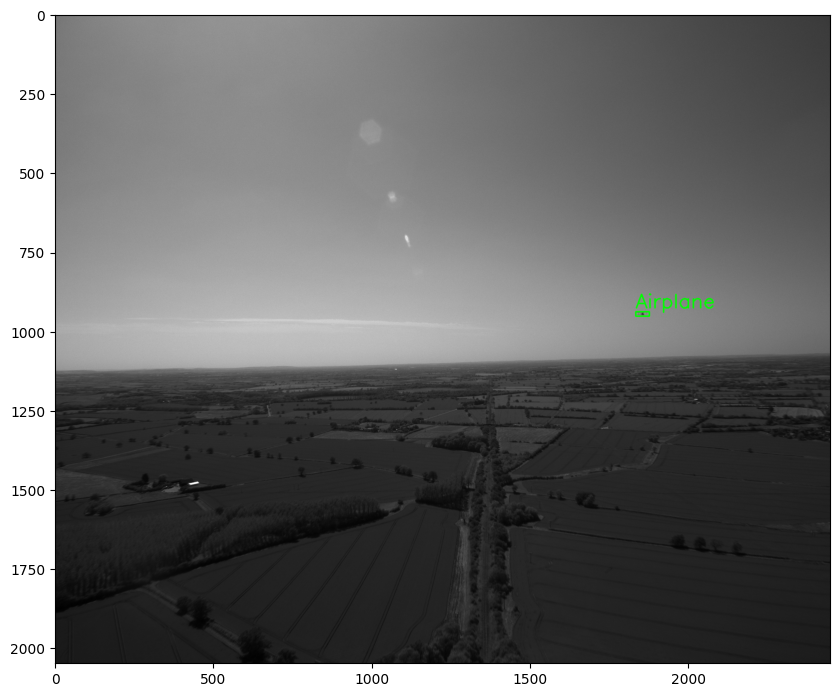

In [15]:
import cv2
import sys
%matplotlib inline
plt.rcParams["figure.figsize"] = 10, 10 # Adjust size of image
def drawBoundingBoxes(imageInputPath, imageOutputPath, inferenceResults, color):
    """Draw bounding boxes on an image.
    imageData: image data in numpy array format
    imageOutputPath: output image file path
    inferenceResults: inference results array off object (l,t,w,h)
    colorMap: Bounding box color candidates, list of RGB tuples.
    """
    imageData = cv2.imread(imageInputPath)
    print(imageData.shape)
    for res in inferenceResults:
        left = int(res['left'])
        top = int(res['top'])
        right = int(res['left']) + int(res['width'])
        bottom = int(res['top']) + int(res['height'])
        label = res['label']
        imgHeight, imgWidth, _ = imageData.shape
        thick = int((imgHeight + imgWidth) // 900)
        print (left, top, right, bottom)
        cv2.rectangle(imageData,(left, top), (right, bottom), color, thick)
        cv2.putText(imageData, label, (left, top - 12), 0, 1e-3 * imgHeight, color, thick)
    plt.imshow(imageData)

target_image = download_images[0][0]
color = (0,255,0)
img_root = 'part1'
frame_df = train_df[df["image_path"] == target_image]
boxes = []
for idx,ob in frame_df.iterrows():
  label,left,top,width,height = ob['object_type'],ob['left'],ob['top'],ob['width'],ob['height']
  box = {}
  box['left'] = left
  box['top'] = top
  box['width'] = width
  box['height'] = height
  box['label'] = label
  boxes.append(box)

drawBoundingBoxes(os.path.join(img_root,target_image),'output.png',boxes,color)


## Setup for training  
Reference: https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_getting_started.html#sphx-glr-auto-examples-transforms-plot-transforms-getting-started-py

In [ ]:
from pathlib import Path
import torch
import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'

from torchvision.transforms import v2
from torchvision.io import read_image

torch.manual_seed(1)

image_path = "/content/drive/MyDrive/Funix-Capstone-Project/data/part1/Images/6c2090577ae043b9b59cfddb7f79cd5b/15675941252918915126c2090577ae043b9b59cfddb7f79cd5b.png"
img = read_image(os.path.join(img_root,target_image))
print(f"{type(img) = }, {img.dtype = }, {img.shape = }")

type(img) = <class 'torch.Tensor'>, img.dtype = torch.uint8, img.shape = torch.Size([1, 2048, 2448])


### Detection with bounding boxes

<ipython-input-93-c534110dec11>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  frame_df = train_df[df["image_path"] == img]


<class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'> <class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'>


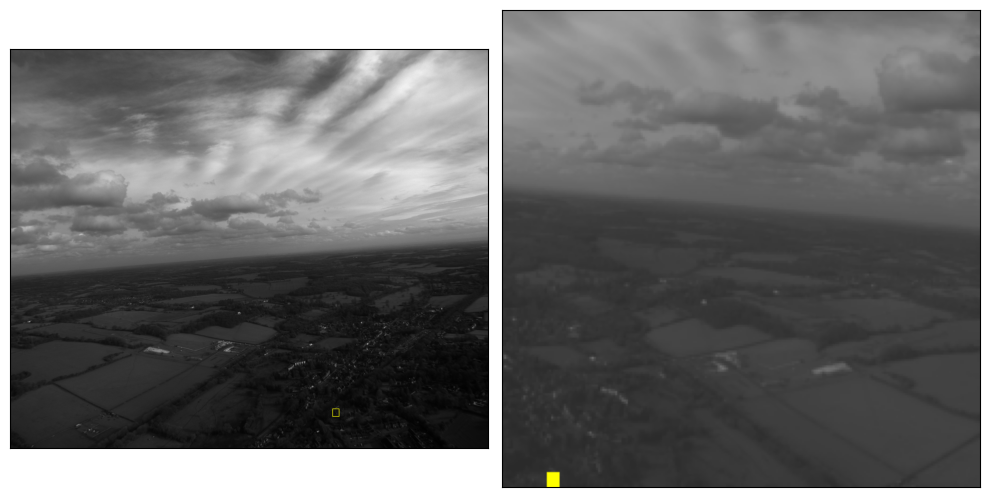

In [ ]:
from torchvision import tv_tensors
from torchvision.utils import draw_bounding_boxes

frame_df = train_df[df["image_path"] == img]
for idx,ob in frame_df.iterrows():
  label,left,top,width,height = ob['object_type'],ob['left'],ob['top'],ob['width'],ob['height']

boxes = tv_tensors.BoundingBoxes(
    [
        [left, top, (left + width), (top + height)]
    ],
    format="XYXY", canvas_size=img.shape[-2:])

# # Convert boxes and labels to tensors
# boxes_tensor = torch.tensor([[left, top, left + width, top + height]], dtype=torch.int)
# labels_tensor = [label]

# # Draw the bounding box with the label
# img_with_boxes = draw_bounding_boxes(img, boxes_tensor, labels=labels_tensor, width=2, colors = 'red')


# plt.imshow(img_with_boxes.permute(1, 2, 0))
# plt.title("Detected Objects")
# plt.axis('off')  # Hide axes
# plt.show()

## Don't transfrom image yet ###
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomPhotometricDistort(p=1),
    v2.RandomHorizontalFlip(p=1),
])
out_img, out_boxes = transforms(img, boxes)
print(type(boxes), type(out_boxes))

plot([(img, boxes), (out_img, out_boxes)], cmap='gray')

Use helper.py to handle retrieval of images, but use own ViT modeling code.

In [13]:
from core.helper import *

# Initialize the enviroment
initialize(42)

# Loading the dataset and save to a variable
# Whether you want to load the entire dataset, use partial=False
#dataset = load_data()

# Print out the dataset
#print(dataset)